# Notes: changed

This code can perform the following tasks:


*   Tune a CNN to directly reconstruct PET images from Sinograms (find a set of hyperparameters)
*   Train a network with a given set of hyperparameters
*   Test the network and record MSE and SSIM values for each image tested
*   Visualize the data and test results
*   Plot training curves, metric histograms, example images

The code is organized into sections. The important sections that you can edit are:


> **User Parameters** - Edit important user parameters and decide what the code will do

> **Configuration Dicts: Supervisory** - Dictionary for supervised learning. Make sure this matches the CNN loaded by the checkpoint file, if you are loading from a checkpoint.

In addition to these, you may find that running a single cell is useful when all variables/classes/files have been loaded into memory. This can be quicker than running everything from scratch.

The cells nested under **Analysis Functions** each have their own changeable parameters.

*Notes:*

*1) Raytune in particular is constantly changing. Therefore, if you are running this code after the authors have ceased maintaining it and there are errors, these are likely due to RayTune classes, methods, or functions being changed. Unfortunately, these seem to happen on a regular basis, as the code is relatively new.*

*2) This code was originally written to tune/train/test not just sinogram to image supervisory networks (sinogram-->image), but also image to sinogram supervisory networks, GANs, CycleGANs, and Cycle + Supervisory networks. These latter capabilities have not been updated, but much of the code survives for this functionality. In the future, the code may be updated once again have these capabilities.*


GPUs
====
From best to worst:

V100 - 6.92/hr

L4 - 2.15/hr

T4 - 1.7/hr

v6e-1 TPU - 4.21/hr

v5e-1 TPU - 4.11/hr

v2-8 TPU - 1.82/hr


# User Parameters

## General

In [51]:
#####################
### General Setup ###
#####################

## Basic Options ##
run_mode='train'  # Options: 'tune' / 'train' / 'test' / 'visualize' / 'none' ('none' builds dictionaries like you are visualizing but does not visualize)
sino_size=320         # Resize input sinograms to this size (integer). Sinograms are square, which was found to give the best results.
sino_channels=3       # Number of channels (sinograms). Options: 1, 3.
image_size=180         # Image size (Options: 90). Images are square.
image_channels=1      # Number of channels (images)
network_type='SUP'    # 'SUP' / 'GAN' / 'CYCLESUP' / 'CYCLEGAN' = (Supervisory only/GAN/Cycle consistency+supervisory/CycleGAN)
train_SI=True         # If working with GAN or SUP networks, set to True build Sinogram-->Image networks, or False for Image --> Sinogram.
SI_normalize=False    # For sino-->image mappings: normalize CNN outputs (images), iterative recons, and ground truths from dataset. You can then adjust the scale factor in the search dictionaries.
IS_normalize=False    # For image-->sinogram mappings: normalize CNN outputs (sinograms), projections, and ground truth sinograms from dataset. You can then adjust scale factor in search dicts.

## Reconstructions in Dataset ##
recon1_scale = 3.350094 # If doing quantitative recons (no normalization), this is the scale factor to multiply optoinal recon1 by
recon2_scale = 1.997523 # If doing quantitative recons (no normalization), this is the scale factor to multiply optoinal recon2 by

## Resources ##
# Resources With Which to Initialize Ray Tune #
num_CPUs=12 # T4:8 L4/V100: 12
num_GPUs=1

# Set Resources Allocated per Trial #
CPUs_per_trial=2
GPUs_per_trial=1

device_opt='sense' # Options: 'sense', 'cuda', 'cpu'. Set to 'sense' to set to 'cpu' if available, else 'cpu'.

## Github Repository for Functions & Classes ##
github_username='petercl8'
repo_name='FlexCNN_for_Medical_Physics'

## Directories ##
project_colab_dirPath = '/content/drive/MyDrive/Colab/Working/'     # Directory, relative to which all other directories are specified (if working on Colab)
project_local_dirPath = r'C:\Users\Peter Lindstrom\My Drive (lindstrom.peter@gmail.com)\Colab\Working'  # Directory, relative to which all other directories are specified (if working Locally)

local_repo_dirPath =  r'C:\FlexCNN_cloned'

data_dirName = 'dataset-sets'      # Dataset directory, placed in project directory (above)
plot_dirName=  'plots'             # Plots Directory, placed in project directory (above)
checkpoint_dirName='checkpoints'   # If not using Ray Tune (not tuning), PyTorch saves and loads checkpoint file from here
                                   # All checkpoint files (for training, testing, visualizing) save the states for a particular network.
                                   # Therefore, the hyperparameters for the loaded CNN must match the data in the checkpoint file.
num_examples=-1                    # Number of examples from dataset to load. Set to -1 to use all examples (this is the default)

## Tuning

In [42]:
############
## Tuning ##
############
# Note: When tuning, ALWAYS select "restart session and run all" from Runtime menu in Google Colab, or there may be bugs.
tune_csv_file='frame-fullSet-highCountSino2actMap-tunedLDM-L' # .csv file to save tuning dataframe to
tune_exp_name='search-fullSet-highCountSino2actMap-tunedLDM-L'  # Experiment directory: Ray tune (and Tensorboard) write to this directory, relative to tune_storage_dirName.
tune_scheduler = 'ASHA'      # Use FIFO for simple first in/first out to train to the end, or ASHA to early stop poorly performing trials.
tune_dataframe_fraction=0.33 # The fraction of the max tuning steps (tune_max_t) at which to save values to the tuning dataframe.
tune_restore=False           # Restore a run (from the file tune_exp_name in tune_storage_dirPath). Use this if a tuning run terminated early for some reason.
tune_minutes = 240           # How long to run RayTune. 180 minutes is good for 180x180 input.
tune_metric = 'CUSTOM'            # Tune for which optimization metric?: 'MSE', 'SSIM', 'CUSTOM' (user defined in the code), 'ROI_NEMA_hot', 'ROI_NEMA_cold', 'ROI_NEMA_weighted'
tune_even_reporting=True     # Set to True to ensure we report to Raytune at an even number of training examples, regardless of batch size.
tune_batches_per_report=4    # If tune_even_reporting = False, this is the number of batches per report (15 works pretty well).
tune_examples_per_report=512*4# If tune_even_reporting = True, this is the number of training examples per Raytune report (~2 batches*512 examples/batch is a good number)
tune_grace_period=4          # Minimum number of reports before terminating a trial
tune_max_t = 25              # Maximum number of reports per network. For even training example reporting (reports made at a constant number of training
                             # examples), 25 is a good number for ASHA. For FIFO, 12 is a good number. For debugging, try 10.
                             # For constant batch size reporting (tune_even_reporting=False), 35 works well.
tune_report_for='val'        # Set to 'val' to report IQA metrics using or cross-validation set. Set to 'qa' to use contrast recovery coefficients for QA phantoms.
tune_eval_batch_size=128     # If tuning on validation set, what is the batch size? Performance os several of these batches are averaged per Ray Tune report (see NUM_EVAL_BATCHES in code)
tune_augment=('SI', True)    # ‘SI’ (sinogram-->image or image--sinogram), “II” (image-->image) or None; True/False = augument by flipping along channels dimension?
tune_debug=False             # Run logger to debug tuning
tune_force_fixed_config=False# Force tuning with a fixed configuration dictionary. This is useful for debugging, to make sure that a network has a good architecture for learning.


## Training Files ##
## -------------- ##
tune_sino_file= 'train-highCountSino-180x180.npy'
#tune_sino_file='train-highCountImage.npy'
#tune_sino_file='train-obliqueImage.npy'
tune_image_file='train-actMap.npy'

tune_recon1_file=None
tune_recon2_file=None
#tune_recon1_file='tune-highCountImage.npy' # Can set recon files to None if dataset does not have these.
#tune_recon2_file='tune-obliqueImage.npy'


## Cross Validation Set ##
## -------------------- ##
tune_val_sino_file='val-highCountSino-180x180.npy'
#tune_val_sino_file='val-highCountImage.npy'
#tune_val_sino_file='val-obliqueImage.npy'
tune_val_image_file='val-actMap.npy'


# QA Phantoms #
tune_qa_hot_weight=0.5 # A weighted contrast recovery coefficient is reported to ray tune as follows: ROI_NEMA_hot * tune_qa_hot_weight + ROI_NEMA_cold * (1-tune_qa_hot_weight)
tune_qa_sino_file='QA-NEMA-highCountSino.npy'
tune_qa_image_file='QA-NEMA-actMap.npy'
tune_qa_hotMask_file='QA-NEMA-hotMask_17mm.npy'
tune_qa_hotBackgroundMask_file='QA-NEMA-backMask_17mm.npy'
tune_qa_coldMask_file='QA-NEMA-coldMask_37mm.npy'
tune_qa_coldBackgroundMask_file='QA-NEMA-backMask_37mm.npy'


## Unlikely to Change ##
tune_storage_dirName='searches'     # Create tuning folders (one for each experiment, each of which contains multiple trials) in this directory. Leave blank ('') to place search files in project directory
tune_dataframe_dirName= 'dataframes-tune'  # Directory for tuning dataframe (stores network information for each network trialed). Code will create it if it doesn't exist.

## Training

In [54]:
##############
## Training ##
##############
#train_checkpoint_file='checkpoint-fullSet-highCountSino2actMap-tunedLDM-augSI-100epochs' # Checkpoint file to load or save to
train_checkpoint_file='temp'

train_load_state=False   # Set to True to load pretrained weights. Use if training terminated early.
train_save_state=False     # Save network weights to train_checkpoint_file file as it trains
train_epochs = 100         # Number of training epochs.
train_display_step=2      # Number of steps/visualization. Good values: for supervised learning or GAN, set to: 50, For cycle-consistent, set to 20
train_sample_division=1    # To evenly sample the training set by a given factor, set this to an integer greater than 1 (ex: to sample every other example, set to 2)
train_show_times=True     # Show calculation times during training?


## Data Files & Augmentations ##
## -------------------------- ##
train_shuffle=True
train_augment=('SI', True)     # ‘SI’ (sinogram-->image or image--sinogram), “II” (image-->image) or None; True/False = augument by flipping along channels dimension?
#train_augment=('II', True)
train_sino_file= 'train-highCountSino-382x513.npy'
#train_sino_file= 'train-highCountSino-180x180.npy'
#train_sino_file='train-highCountImage.npy'
train_image_file='train-actMap.npy'

train_recon1_file=None
train_recon2_file=None
#train_recon1_file='train-highCountImage.npy'  # Can set recon files to None if dataset does not have these.
#train_recon2_file='train-obliqueImage.npy'

## Testing

In [44]:
###########
# Testing #
###########
test_dataframe_dirName= 'TestOnFull'  # Directory for test metric dataframes
test_csv_file = 'combined-tunedLowSSIM-trainedLowSSIM-onTestSet-wMLEM' # csv dataframe file to save testing results to
test_checkpoint_file='checkpoint-tunedLowSSIM-trainedLowSSIM-100epochs' # Checkpoint to load model for testing

test_display_step=15        # Make this a larger number to save bit of time (displays images/metrics less often)
test_batch_size=25          # This doesn't affect the final metrics, just the displayed metrics as testing procedes
test_chunk_size=875              # How many examples do you want to test at once? NOTE: This should be a multiple of test_batch_size AND also go into the test set size evenly.
testset_size=35000          # Size of the set to test. This must be <= the number of examples in your test set file.
test_begin_at=0             # Begin testing at this example number.
test_compute_MLEM=False          # Compute a simple MLEM reconstruction from the sinograms when running testing.
                            # This takes a lot longer. If set to false, only FBP is calculated.
test_merge_dataframes=True  # Merge the smaller/chunked dataframes at the end of the test run into one large dataframe?
test_show_times=False       # Show calculation times?
test_shuffle=False
test_sample_division=1

## Select Data Files ##
## ----------------- ##
test_sino_file= 'test-highCountSino-180x180.npy'
test_image_file= 'test-actMap.npy'
test_recon1_file='test-highCountImage.npy'
test_recon2_file='test-obliqueImage.npy'

#test_sino_file=  'test_sino-35k.npy'
#test_image_file= 'test_image-35k.npy'
#test_sino_file= 'test_sino-highMSE-8750.npy'
#test_image_file= 'test_image-highMSE-8750.npy'
#test_sino_file= 'test_sino-lowMSE-8750.npy'
#test_image_file= 'test_image-lowMSE-8750.npy'

## Visualizing

In [45]:
####################
## Visualize Data ##
####################
#visualize_sino_file= 'train-highCountSino-180x180.npy'
visualize_sino_file= 'train-highCountSino-382x513.npy'
visualize_image_file='train-actMap.npy'
visualize_recon1_file='train-highCountImage.npy'  # Can set recon files to None if dataset does not have these.
visualize_recon2_file='train-obliqueImage.npy'
#visualize_recon1_file=None
#visualize_recon2_file=None

#visualize_checkpoint_file='checkpoint-90x1-tunedMSE-fc6-6epochs' # Checkpoint file to load/save
visualize_checkpoint_file='checkpoint-new_data-old_net-180x180-temp'
visualize_batch_size = 10   # Set value to exactly 120 to see a large grid of images OR =<10 for reconstructions
                            #  and ground truth with matched color scales
visualize_offset=0          # Image to begin at. Set to 0 to start at beginning.
visualize_shuffle=True      # Shuffle data set when visualizing?

# Install Required Packages

## Some Setup Funcs

In [46]:
import os, sys, glob, importlib, inspect, types, subprocess, pkgutil

def sense_colab():
    try:
        import google.colab
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False
    return IN_COLAB

def sense_device(device='sense'):
    if device == 'sense':
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'
    elif device == 'cpu':
        device = 'cpu'
    elif device == 'cuda':
        device = 'cuda'
    return device

def install_required_packages_ray_version(IN_COLAB, force_reinstall=False, include_optional=True, ray_version=None):
    """
    Installs required Python packages efficiently.
    - Detects if running in Colab or locally.
    - Installs missing packages only (unless force_reinstall=True).
    - Ensures Ray Tune dependencies are installed even if ray is already present.
    - Can pin Ray version with ray_version (e.g., "1.12.0").
    """

    # Base list of packages
    packages = [
        "torch", "torchvision", "torchaudio",
        "ray[tune]", "tensorboardX", "hyperopt",
        "numpy", "pandas", "matplotlib",
        "scikit-image", "scipy"
    ]

    # Optional packages for visualization
    optional_packages = ["tensorboard"]
    widgets_packages = ["ipywidgets"]
    missing = []

    for pkg in packages:
        pkg_name = pkg.split("[")[0]

        # Special handling for Ray Tune
        if pkg_name == "ray":
            try:
                import ray
                import ray.tune
                ray_tune_installed = True
            except ImportError:
                ray_tune_installed = False

            # Build the package name with version if specified
            if ray_version:
                pkg = f"ray[{ 'tune' if 'tune' in pkg else ''}]=={ray_version}"

            if force_reinstall or not ray_tune_installed:
                missing.append(pkg)
            continue

        # General case
        if importlib.util.find_spec(pkg_name) is None or force_reinstall:
            missing.append(pkg)

    # Optionally add optional packages
    if include_optional:
        missing += optional_packages + widgets_packages

    if not missing:
        print("✅ All required packages already installed.")
        return

    print(f"📦 Installing missing packages: {', '.join(missing)}")

    # Build pip command
    if IN_COLAB:
        cmd = ["pip", "install", "--upgrade"] + missing
    else:
        cmd = [sys.executable, "-m", "pip", "install", "--upgrade"] + missing

    try:
        subprocess.check_call(cmd)
        print("✅ Installation complete.")
    except subprocess.CalledProcessError as e:
        print(f"❌ Installation failed: {e}")

def install_required_packages_forceGPU(IN_COLAB=True, force_reinstall=False, include_optional=True):
    """
    Installs required Python packages efficiently.
    - Detects if running in Colab or locally.
    - Installs missing packages only (unless force_reinstall=True).
    - Automatically installs GPU-enabled PyTorch if a CUDA-capable GPU is detected.
    """

    # Base list of non-PyTorch packages
    other_packages = [
        "ray[tune]", "tensorboardX", "hyperopt",
        "numpy", "pandas", "matplotlib",
        "scikit-image", "scipy"
    ]

    # Optional packages
    optional_packages = ["tensorboard"]
    widgets_packages = ["ipywidgets"]

    missing = []

    # ------------------------------
    # PyTorch: detect CPU vs GPU
    # ------------------------------
    torch_packages = ["torch", "torchvision", "torchaudio"]
    pip_index_url = []

    cuda_available = False
    try:
        import torch
        cuda_available = torch.cuda.is_available()
    except ImportError:
        pass

    if not IN_COLAB and not cuda_available:
        # Check GPU presence on Windows via nvidia-smi
        try:
            gpu_info = subprocess.check_output("nvidia-smi", shell=True).decode()
            if "failed" not in gpu_info.lower():
                cuda_available = True
        except Exception:
            pass

    # If local GPU detected, uninstall CPU-only PyTorch first and set CUDA URL
    if cuda_available and not IN_COLAB:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "torch", "torchvision", "torchaudio"])
        except subprocess.CalledProcessError:
            # Ignore if PyTorch is not installed
            pass
        pip_index_url = ["--index-url", "https://download.pytorch.org/whl/cu124"]

    # ------------------------------
    # Check other packages
    # ------------------------------
    for pkg in other_packages:
        pkg_name = pkg.split("[")[0]
        if pkg_name == "ray":
            try:
                import ray
                import ray.tune
                ray_tune_installed = True
            except ImportError:
                ray_tune_installed = False
            if force_reinstall or not ray_tune_installed:
                missing.append(pkg)
            continue

        if importlib.util.find_spec(pkg_name) is None or force_reinstall:
            missing.append(pkg)

    # Add optional packages
    if include_optional:
        missing += optional_packages + widgets_packages

    # Remove duplicates
    missing = list(dict.fromkeys(missing))

    if not missing and not force_reinstall:
        print("✅ All required packages already installed.")
        return

    print(f"📦 Installing missing packages: {', '.join(torch_packages + missing)}")

    # ------------------------------
    # Build pip command
    # ------------------------------
    if IN_COLAB:
        cmd = ["pip", "install", "--upgrade"] + torch_packages + missing + pip_index_url
    else:
        cmd = [sys.executable, "-m", "pip", "install", "--upgrade"] + torch_packages + missing + pip_index_url

    # ------------------------------
    # Run pip install
    # ------------------------------
    try:
        subprocess.check_call(cmd)
        print("✅ Installation complete.")
    except subprocess.CalledProcessError as e:
        print(f"❌ Installation failed: {e}")

    # ------------------------------
    # Confirm CUDA availability
    # ------------------------------
    try:
        import torch
        if torch.cuda.is_available():
            print(f"✅ PyTorch CUDA detected: {torch.cuda.get_device_name(0)}")
        else:
            print("⚠️ PyTorch installed, but no GPU detected. Using CPU-only build.")
    except ImportError:
        print("❌ PyTorch installation failed completely.")

def install_required_packages(IN_COLAB=True, force_reinstall=False, include_optional=True):
    """
    Installs required Python packages efficiently.
    - Detects if running in Colab or locally.
    - Installs missing packages only (unless force_reinstall=True).
    - Ensures Ray Tune dependencies are installed even if ray is already present.
    """

    # Base list of packages
    packages = [
        "torch", "torchvision", "torchaudio",
        "ray[tune]", "tensorboardX", "hyperopt",
        "numpy", "pandas", "matplotlib",
        "scikit-image", "scipy"
    ]

    # Optional packages for visualization
    optional_packages = ["tensorboard"]
    # Widgets for tqdm are optional; plain progress bar is fine
    widgets_packages = ["ipywidgets"]
    missing = []

    for pkg in packages:
        pkg_name = pkg.split("[")[0]

        # Special handling for Ray Tune
        if pkg_name == "ray":
            try:
                import ray
                import ray.tune
                ray_tune_installed = True
            except ImportError:
                ray_tune_installed = False
            if force_reinstall or not ray_tune_installed:
                missing.append(pkg)
            continue

        # General case
        if importlib.util.find_spec(pkg_name) is None or force_reinstall:
            missing.append(pkg)

    # Optionally add optional packages
    if include_optional:
        missing += optional_packages + widgets_packages

    if not missing:
        print("✅ All required packages already installed.")
        return

    print(f"📦 Installing missing packages: {', '.join(missing)}")

    # Build pip command
    if IN_COLAB:
        cmd = ["pip", "install", "--upgrade"] + missing
    else:
        cmd = [sys.executable, "-m", "pip", "install", "--upgrade"] + missing

    try:
        subprocess.check_call(cmd)
        print("✅ Installation complete.")
    except subprocess.CalledProcessError as e:
        print(f"❌ Installation failed: {e}")

def refresh_repo(
    IN_COLAB = True,
    repo_name: str = "FlexCNN_for_Medical_Physics",
    github_username: str = "petercl8",
    local_repo_path: str = None,
    auto_import: bool = True,
    verbose: bool = True):
    """
    Clone/pull and install the repo, then optionally auto-import all modules.
    Also reloads all submodules to reflect changes without restarting the runtime.
    """
    # --- Determine base directory ---
    base_dir = "/content" if IN_COLAB else local_repo_path
    if base_dir is None:
        raise ValueError("local_repo_path must be provided if not in Colab")

    repo_path = os.path.join(base_dir, repo_name)
    repo_url = (
        f"https://github.com/{github_username}/{repo_name}.git"
        if IN_COLAB
        else f"git@github.com:{github_username}/{repo_name}.git"
    )

    # --- Clone or update ---
    if not os.path.exists(repo_path):
        if verbose:
            print(f"📦 Cloning {repo_name} into {base_dir}...")
        subprocess.run(["git", "clone", repo_url], cwd=base_dir, check=True)
    else:
        if verbose:
            print(f"🔄 Pulling latest changes in {repo_path}...")
        subprocess.run(["git", "pull"], cwd=repo_path, check=True)

    # --- Install package in editable mode ---
    if verbose:
        print("⚙️ Installing the package in editable mode...")
    subprocess.run([sys.executable, "-m", "pip", "install", "-e", "."],
                   cwd=repo_path, check=True)

    # --- Ensure repo path is importable ---
    if repo_path not in sys.path:
        sys.path.insert(0, repo_path)

    # --- Import the package ---
    package = importlib.import_module(repo_name)

    # --- Reload all submodules recursively ---
    def reload_submodules(pkg):
        for _, modname, ispkg in pkgutil.walk_packages(pkg.__path__, pkg.__name__ + "."):
            if modname in sys.modules:
                importlib.reload(sys.modules[modname])
            else:
                importlib.import_module(modname)
        importlib.reload(pkg)

    reload_submodules(package)

    # --- Gather all symbols ---
    imported = {}
    for _, modname, ispkg in pkgutil.walk_packages(package.__path__, package.__name__ + "."):
        mod = importlib.import_module(modname)
        for name, obj in inspect.getmembers(mod):
            if not name.startswith("_"):
                imported[name] = obj

    # --- Inject symbols into caller's globals if requested ---
    if auto_import:
        if verbose:
            print("✨ Injecting all symbols into global namespace...")
        caller_globals = inspect.stack()[1].frame.f_globals
        caller_globals.update(imported)
        if verbose:
            print(f"✅ Setup complete: {len(imported)} symbols loaded into globals.")
    else:
        if verbose:
            print(f"✅ Imported {len(imported)} symbols (not injected).")


## Install Packages

In [47]:
# --- Sense environment ---
IN_COLAB = sense_colab()

# --- Install packages and import ---
install_required_packages(IN_COLAB)

📦 Installing missing packages: scikit-image, tensorboard, ipywidgets
✅ Installation complete.


## Finish Setup

In [56]:
# --- Refresh Repository ---
refresh_repo(IN_COLAB, local_repo_path=local_repo_dirPath)

# --- Test Resources ---
list_compute_resources()

# --- Set main project directory
project_dirPath = setup_project_dirs(IN_COLAB, project_local_dirPath, project_colab_dirPath, mount_colab_drive=True)

# --- Set Device ---
device = sense_device(device=device_opt)

# Build grouped parameter dictionaries #

common_settings = {
    'run_mode': run_mode,
    'device': device,
    'num_examples': num_examples,
    'recon1_scale': recon1_scale,
    'recon2_scale': recon2_scale
}

base_dirs = {
    'project_dirPath': project_dirPath,
    'plot_dirName': plot_dirName,
    'checkpoint_dirName': checkpoint_dirName,
    'tune_storage_dirName': tune_storage_dirName,
    'tune_dataframe_dirName': tune_dataframe_dirName,
    'test_dataframe_dirName': test_dataframe_dirName,
    'data_dirName': data_dirName
}

data_files = {
    'tune_sino_file': tune_sino_file,
    'tune_image_file': tune_image_file,
    'tune_recon1_file': tune_recon1_file,
    'tune_recon2_file': tune_recon2_file,
    'tune_val_sino_file': tune_val_sino_file,
    'tune_val_image_file': tune_val_image_file,
    'tune_qa_sino_file': tune_qa_sino_file,
    'tune_qa_image_file': tune_qa_image_file,
    'tune_qa_hotMask_file': tune_qa_hotMask_file,
    'tune_qa_hotBackgroundMask_file': tune_qa_hotBackgroundMask_file,
    'tune_qa_coldMask_file': tune_qa_coldMask_file,
    'tune_qa_coldBackgroundMask_file': tune_qa_coldBackgroundMask_file,
    'train_sino_file': train_sino_file,
    'train_image_file': train_image_file,
    'train_recon1_file': train_recon1_file,
    'train_recon2_file': train_recon2_file,
    'test_sino_file': test_sino_file,
    'test_image_file': test_image_file,
    'test_recon1_file': test_recon1_file,
    'test_recon2_file': test_recon2_file,
    'visualize_sino_file': visualize_sino_file,
    'visualize_image_file': visualize_image_file,
    'visualize_recon1_file': visualize_recon1_file,
    'visualize_recon2_file': visualize_recon2_file,

    }

mode_files = {
    'tune_csv_file': tune_csv_file,
    'train_checkpoint_file': train_checkpoint_file,
    'test_checkpoint_file': test_checkpoint_file,
    'test_csv_file': test_csv_file,
    'visualize_checkpoint_file': visualize_checkpoint_file
}

network_opts = {
    'network_type': network_type,
    'train_SI': train_SI,
    'image_size': image_size,
    'sino_size': sino_size,
    'image_channels': image_channels,
    'sino_channels': sino_channels,
    'SI_normalize': SI_normalize,
    'IS_normalize': IS_normalize,
}

tune_opts = {
    'tune_exp_name': tune_exp_name,
    'tune_scheduler': tune_scheduler,
    'tune_dataframe_fraction': tune_dataframe_fraction,
    'tune_restore': tune_restore,
    'tune_max_t': tune_max_t,
    'tune_minutes': tune_minutes,
    'tune_metric': tune_metric,
    'tune_even_reporting': tune_even_reporting,
    'tune_batches_per_report': tune_batches_per_report,
    'tune_examples_per_report': tune_examples_per_report,
    'tune_augment': tune_augment,
    'tune_grace_period': tune_grace_period,
    'tune_debug': tune_debug,
    'tune_force_fixed_config': tune_force_fixed_config,
    'tune_report_for': tune_report_for,
    'tune_qa_hot_weight': tune_qa_hot_weight,
    'tune_eval_batch_size': tune_eval_batch_size,
    'num_CPUs': num_CPUs,
    'num_GPUs': num_GPUs,
    'cpus_per_trial': CPUs_per_trial,  # per trial
    'gpus_per_trial': GPUs_per_trial,  # per trial
}

train_opts = {
    'train_load_state': train_load_state,
    'train_save_state': train_save_state,
    'training_epochs': train_epochs,
    'train_augment': train_augment,
    'train_shuffle': train_shuffle,
    'train_display_step': train_display_step,
    'train_sample_division': train_sample_division,
    'train_show_times': train_show_times,
}

test_opts = {
    'test_display_step': test_display_step,
    'test_batch_size': test_batch_size,
    'test_chunk_size': test_chunk_size,
    'testset_size': testset_size,
    'test_begin_at': test_begin_at,
    'test_compute_MLEM': test_compute_MLEM,
    'test_merge_dataframes': test_merge_dataframes,
    'test_show_times': test_show_times,
    'test_shuffle': test_sample_division,
    'test_sample_division': test_sample_division
}

viz_opts = {
    'visualize_batch_size': visualize_batch_size,
    'visualize_offset': visualize_offset,
    'visualize_shuffle': visualize_shuffle,
}

# Build paths and settings using new functions
paths = setup_paths(
    run_mode=run_mode,
    base_dirs=base_dirs,
    data_files=data_files,
    mode_files=mode_files,
    test_ops=test_opts,
    viz_ops=viz_opts
)

settings = setup_settings(
    run_mode=run_mode,
    common_settings=common_settings,
    tune_opts=tune_opts,
    train_opts=train_opts,
    test_opts=test_opts,
    viz_opts=viz_opts,
)

# --- Build Config Dictionary ---
config = construct_config(
    run_mode=run_mode,
    network_opts=network_opts,
    tune_opts=tune_opts,
    test_opts=test_opts,
    viz_opts=viz_opts,
    config_SUP_SI=config_SUP_SI,
    config_SUP_IS=config_SUP_IS,
    config_GAN_SI=config_GAN_SI,
    config_GAN_IS=config_GAN_IS,
    config_CYCLEGAN=config_CYCLEGAN,
    config_CYCLESUP=config_CYCLESUP,
    config_RAY_SI=config_RAY_SI,
    config_RAY_SI_learnScale=config_RAY_SI_learnScale,
    config_RAY_SI_fixedScale=config_RAY_SI_fixedScale,
    config_RAY_IS=config_RAY_IS,
    config_RAY_IS_learnScale=config_RAY_IS_learnScale,
    config_RAY_IS_fixedScale=config_RAY_IS_fixedScale,
    config_RAY_SUP=config_RAY_SUP,
    config_RAY_GAN=config_RAY_GAN,
    config_SUP_RAY_cycle=config_SUP_RAY_cycle,
    config_GAN_RAY_cycle=config_GAN_RAY_cycle,
)

print ("=============")
print ("Current Paths")
print("=============")
print(paths)

print ("=============")
print ("Current Settings")
print("=============")
print(settings)

print ("=============")
print("Current Config")
print("=============")
print(config)

🔄 Pulling latest changes in /content/FlexCNN_for_Medical_Physics...
⚙️ Installing the package in editable mode...
✨ Injecting all symbols into global namespace...
✅ Setup complete: 170 symbols loaded into globals.
CPUs available: 8
GPUs available: 0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Paths
{'plot_dirPath': '/content/drive/MyDrive/Colab/Working/plots', 'checkpoint_dirPath': '/content/drive/MyDrive/Colab/Working/checkpoints', 'tune_storage_dirPath': '/content/drive/MyDrive/Colab/Working/searches', 'tune_dataframe_dirPath': '/content/drive/MyDrive/Colab/Working/dataframes-tune', 'test_dataframe_dirPath': '/content/drive/MyDrive/Colab/Working/TestOnFull', 'data_dirPath': '/content/drive/MyDrive/Colab/Working/dataset-sets', 'tune_sino_path': '/content/drive/MyDrive/Colab/Working/dataset-sets/train-highCountSino-180x180.npy', 'tune_image_path': '/content/drive/MyDrive/Colab/Working/dataset-s

# (!) Run Pipeline

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


loader time (ms): 1796.3740825653076
FULL STEP TIME (ms): 1796.468734741211
training time (ms): 1334.6869945526123
metrics time (ms): 56.98537826538086
loader time (ms): 1049.361228942871
FULL STEP TIME (ms): 2441.3044452667236
training time (ms): 1198.7645626068115
metrics time (ms): 55.295705795288086
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 2 / image #: 64
mean_gen_loss: 204.50212860107422
mean_CNN_MSE : 204.50212148576975
mean_CNN_SSIM: 0.09120029791665729
Last Batch MSE:  194.37959015369415
Last Batch SSIM:  0.0942456125485478
Last Batch LDM:  (2307.864990234375, {1: 5071.271484375, 2: 1852.3236083984375})
Input Sinogram:
Shape: torch.Size([2, 1, 320, 320]) // Min: 0.0 // Max: 13.830493927001953     //Mean Sum (per image): 17129.35546875 // Sum (a single image): 17692.5859375


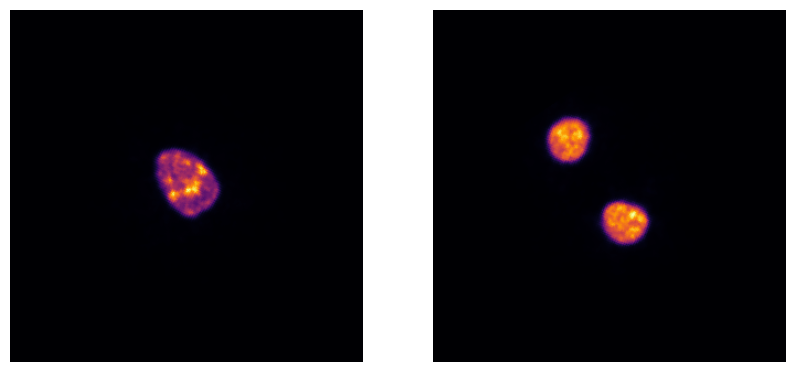

torch.Size([32, 1, 320, 320])
Target/Output:
Shape: torch.Size([8, 1, 180, 180]) // Min: 0.0 // Max: 161.67799377441406         // Mean: 3.809539318084717 // Mean Sum (per image): 123429.0703125 // Sum (a single image): 56673.47265625
Shape: torch.Size([8, 1, 180, 180]) // Min: 1.3022687816999223e-08 // Max: 4.208919048309326         // Mean: 2.3798234462738037 // Mean Sum (per image): 77106.28125 // Sum (a single image): 75173.9921875


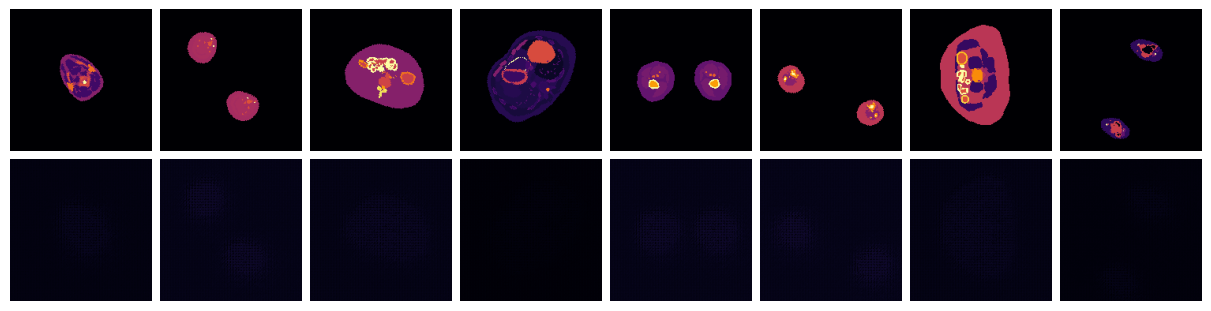

visualization time (ms): 445.2672004699707
loader time (ms): 1111.8927001953125
FULL STEP TIME (ms): 2811.5036487579346
training time (ms): 1168.0152416229248
metrics time (ms): 55.29141426086426
loader time (ms): 856.5645217895508
FULL STEP TIME (ms): 2080.120801925659
training time (ms): 1169.5737838745117
metrics time (ms): 55.806875228881836
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 4 / image #: 128
mean_gen_loss: 210.00479888916016
mean_CNN_MSE : 210.0048025250435
mean_CNN_SSIM: 0.1300556005880935
Last Batch MSE:  238.17271369695663
Last Batch SSIM:  0.11792470692307688
Last Batch LDM:  (2339.394775390625, {1: 4875.9931640625, 2: 2142.19091796875})
Input Sinogram:
Shape: torch.Size([2, 1, 320, 320]) // Min: 0.0 // Max: 20.68304443359375     //Mean Sum (per image): 40259.60546875 // Sum (a single image): 63226.6015625


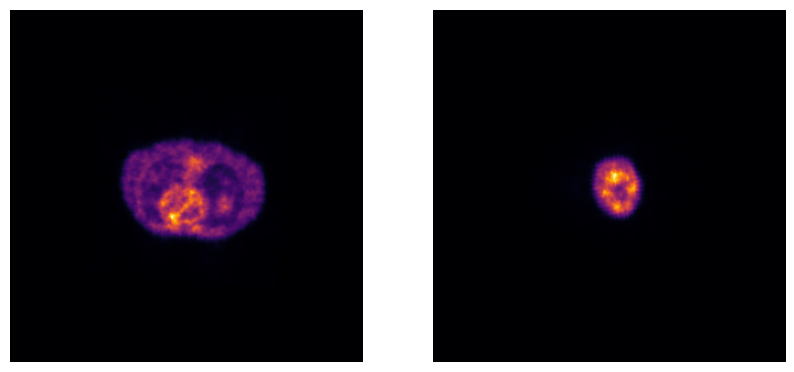

torch.Size([32, 1, 320, 320])
Target/Output:
Shape: torch.Size([8, 1, 180, 180]) // Min: 0.0 // Max: 377.0360107421875         // Mean: 4.779938697814941 // Mean Sum (per image): 154870.015625 // Sum (a single image): 216092.0
Shape: torch.Size([8, 1, 180, 180]) // Min: 1.015927679759443e-07 // Max: 4.21710729598999         // Mean: 2.4427075386047363 // Mean Sum (per image): 79143.7265625 // Sum (a single image): 83079.78125


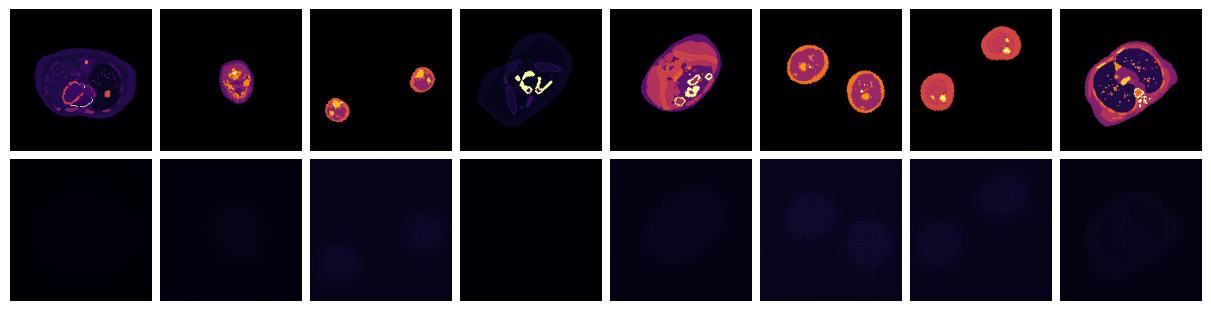

visualization time (ms): 422.5013256072998
loader time (ms): 363.70110511779785
FULL STEP TIME (ms): 2011.8625164031982
training time (ms): 1078.9403915405273
metrics time (ms): 59.61871147155762
loader time (ms): 897.7885246276855
FULL STEP TIME (ms): 2036.604404449463
training time (ms): 1171.5385913848877
metrics time (ms): 53.351640701293945
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 6 / image #: 192
mean_gen_loss: 195.2927017211914
mean_CNN_MSE : 195.29269403219223
mean_CNN_SSIM: 0.13629328145179898
Last Batch MSE:  176.68918561935425
Last Batch SSIM:  0.14848307470674627
Last Batch LDM:  (2322.5341796875, {1: 4564.25537109375, 2: 2403.346923828125})
Input Sinogram:
Shape: torch.Size([2, 1, 320, 320]) // Min: 0.0 // Max: 23.193639755249023     //Mean Sum (per image): 44420.9609375 // Sum (a single image): 67250.6796875


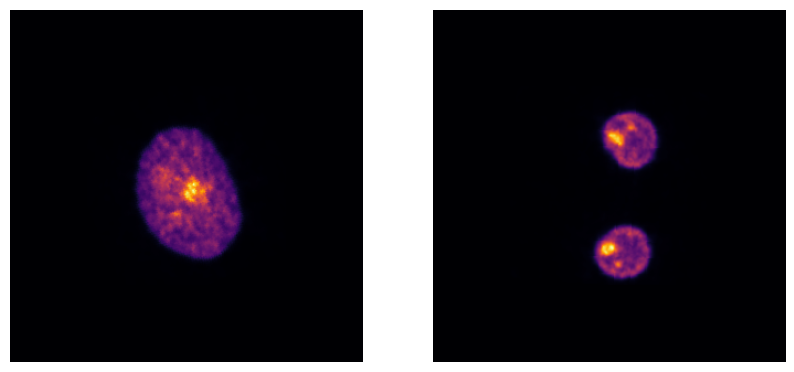

torch.Size([32, 1, 320, 320])
Target/Output:
Shape: torch.Size([8, 1, 180, 180]) // Min: 0.0 // Max: 266.70599365234375         // Mean: 3.1754794120788574 // Mean Sum (per image): 102885.53125 // Sum (a single image): 220166.953125
Shape: torch.Size([8, 1, 180, 180]) // Min: 2.000497767440379e-09 // Max: 4.225423336029053         // Mean: 2.4175801277160645 // Mean Sum (per image): 78329.59375 // Sum (a single image): 83789.1875


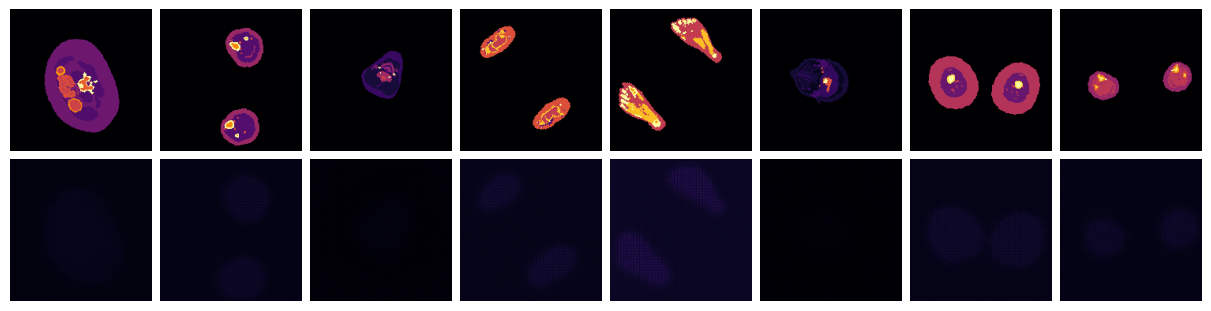

visualization time (ms): 439.04900550842285
loader time (ms): 319.4997310638428
FULL STEP TIME (ms): 1983.720064163208
training time (ms): 1124.934196472168
metrics time (ms): 54.17656898498535
loader time (ms): 299.3283271789551
FULL STEP TIME (ms): 1478.6913394927979
training time (ms): 1516.9956684112549
metrics time (ms): 58.65597724914551
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 8 / image #: 256
mean_gen_loss: 171.80593872070312
mean_CNN_MSE : 171.80593091249466
mean_CNN_SSIM: 0.14009839984646533
Last Batch MSE:  156.24401772022247
Last Batch SSIM:  0.14302180489175953
Last Batch LDM:  (2287.419677734375, {1: 4173.12744140625, 2: 2689.1318359375})
Input Sinogram:
Shape: torch.Size([2, 1, 320, 320]) // Min: 0.0 // Max: 15.993743896484375     //Mean Sum (per image): 27194.109375 // Sum (a single image): 10264.9052734375


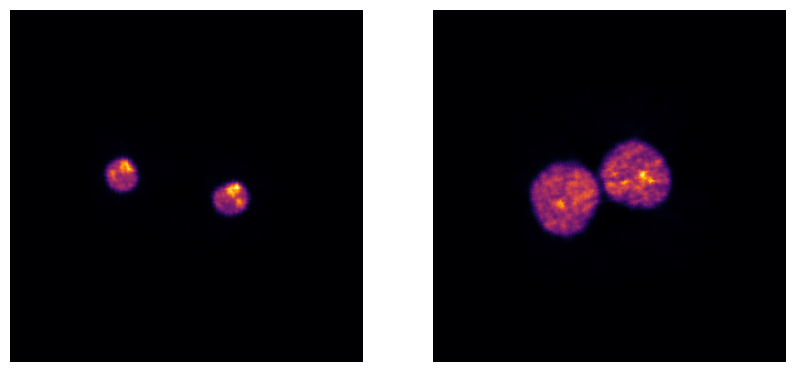

torch.Size([32, 1, 320, 320])
Target/Output:
Shape: torch.Size([8, 1, 180, 180]) // Min: 0.0 // Max: 309.71600341796875         // Mean: 3.156442642211914 // Mean Sum (per image): 102268.7421875 // Sum (a single image): 34723.10546875
Shape: torch.Size([8, 1, 180, 180]) // Min: 2.7207902597581324e-09 // Max: 4.233711242675781         // Mean: 2.4257876873016357 // Mean Sum (per image): 78595.5234375 // Sum (a single image): 74596.625


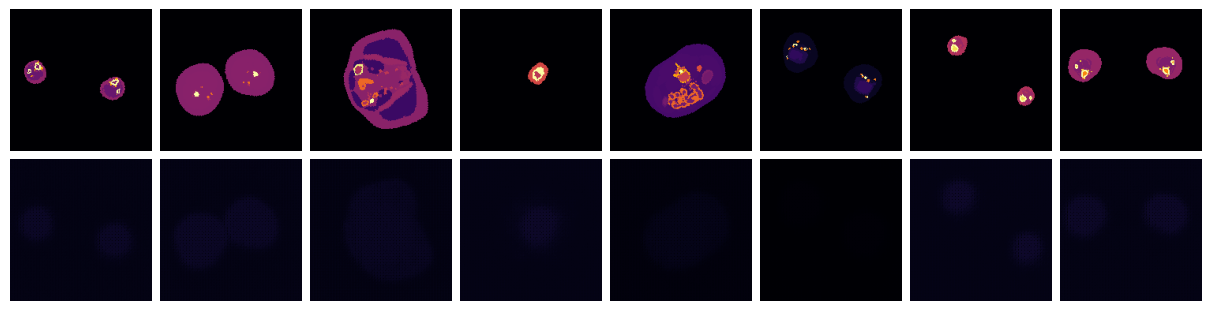

visualization time (ms): 406.0394763946533
loader time (ms): 334.13219451904297
FULL STEP TIME (ms): 2316.1041736602783
training time (ms): 1311.4213943481445
metrics time (ms): 54.20827865600586
loader time (ms): 307.62171745300293
FULL STEP TIME (ms): 1673.5420227050781


KeyboardInterrupt: 

In [57]:
# --- Run Pipeline ---
run_pipeline(
    config=config,
    paths=paths,
    settings=settings,
    tune_opts=tune_opts,
    base_dirs=base_dirs,
    test_opts=test_opts
)

# Analysis

## Compute Recon Scales



In [ ]:
compute_scales=False

if compute_scales=True:
    #avg_activity = compute_average_activity_per_image(paths, dataset='train')

    #scales1 = compute_quantitative_reconstruction_scale(paths, dataset='train')
    #scales2 = analyze_reconstruction_scale_distribution(paths, dataset='train', sample_mode='full', sample_size=1000, ratio_cap_multiple=None)

**Absolute Activities**


*   Average activity per image: 144616.84
*   Std dev activity per image: 89057.51
*   Min activity per image: 13.16
*   Max activity per image: 640712.82

**Quantitative Reconstruction Scales:**

Training Set:

*   FORE: 3.350
*   Oblique: 1.998

Test Set:

*   FORE: 3.412
*   Oblique: 2.014

**Analysis Scales for No Cap:**

Training set:

*   FORE: 3.400 +/0 0.305 (max_ratio = 4.768)
*   Oblique: 2.025 +/- 0.077 (max_ratio = 2.658)

Test set:

*   FORE: 3.426 +/- 0.292 (max_ratio = 4.727)
*   Oblique: 2.034 +/- 0.073 (max_ratio = 2.683)








## Plot Example Images

In [ ]:
# --- Refresh Repository ---
#refresh_repo(IN_COLAB, local_repo_path=local_repo_dirPath)

## Anthropomorphic phantoms ##
##############################
fig_size_XCAT=2.5
indexes_XCAT = [100, 200, 300, 400, 500, 600, 700]

test_array_names = ['test-actMap.npy', 'test-obliqueImage.npy', 'test-highCountImage.npy',]
test_sino = 'test-highCountSino-180x180.npy'
#test_sino = 'test-highCountImage.npy'

train_array_names = ['train-actMap.npy','train-obliqueImage.npy', 'train-highCountImage.npy', ]
train_sino = 'train-highCountSino-180x180.npy'
#train_sino = 'train-highCountImage.npy'

## QA phantoms ##
#################
fig_size_QA=2.5
indexes_QA = [13, 14, 15, 16, 17, 18, 19]

NEMA_array_names = ['QA-NEMA-actMap.npy','QA-NEMA-obliqueImage.npy', 'QA-NEMA-highCountImage.npy',]
NEMA_sino = 'QA-NEMA-highCountSino.npy'
#NEMA_sino = 'QA-NEMA-highCountImage.npy'

Pinwheel_array_names = ['QA-Pinwheel-actMap.npy','QA-Pinwheel-obliqueImage.npy', 'QA-Pinwheel-highCountImage.npy']
Pinwheel_sino = 'QA-Pinwheel-highCountSino.npy'
#Pinwheel_sino = 'QA-Pinwheel-highCountImage.npy'

Radial_array_names = ['QA-Radial-actMap.npy','QA-Radial-obliqueImage.npy', 'QA-Radial-highCountImage.npy']
Radial_sino = 'QA-Radial-highCountSino.npy'
#Radial_sino = 'QA-Radial-highCountImage.npy'

#actMap = 'QA-Axial-actMap.npy'
#sino = 'QA-Axial-highCountSino.npy'

## Network Configs ##
#####################

checkpoint_fileName_SI = 'checkpoint-fullSet-highCountSino2actMap-tunedSSIM-augII-100epochs'
config_SI = {
   "SI_dropout": False,
  "SI_exp_kernel": 3,
  "SI_fixedScale": 1,
  "SI_gen_fill": 1,
  "SI_gen_final_activ": nn.ELU(alpha=1.0),
  "SI_gen_hidden_dim": 29,
  "SI_gen_mult": 1.5090047574838394,
  "SI_gen_neck": 11,
  "SI_gen_z_dim": 486,
  "SI_layer_norm": "instance",
  "SI_learnedScale_init": 20.45467480669682,
  "SI_normalize": False,
  "SI_pad_mode": "zeros",
  "SI_skip_mode": "none",
  "batch_base2_exponent": 6,
  "gen_b1": 0.34632557248900636,
  "gen_b2": 0.10963336318792913,
  "gen_lr": 0.0005750756280291565,
  "image_channels": 1,
  "image_size": 180,
  "network_type": "SUP",
  "sino_channels": 3,
  "sino_size": 180,
  "sup_criterion": nn.MSELoss(),
  "train_SI": True
}

### Plots Images ###
####################

#image_tensor, sino_tensor = PlotPhantomRecons(test_array_names, test_sino, config_SI, paths, indexes_XCAT, checkpoint_fileName_SI, fig_size_XCAT, device)
#show_single_unmatched_tensor(sino_tensor[0:2], fig_size=10)

#image_tensor, sino_tensor = PlotPhantomRecons(NEMA_array_names, NEMA_sino, config_SI, paths, indexes_QA, checkpoint_fileName_SI, fig_size_QA, device)
image_tensor, sino_tensor = PlotPhantomRecons(Pinwheel_array_names, Pinwheel_sino, config_SI, paths, indexes_QA, checkpoint_fileName_SI, fig_size_QA, device)
show_single_unmatched_tensor(sino_tensor[0:2], fig_size=25)

#image_tensor, sino_tensor = PlotPhantomRecons(Radial_array_names, Radial_sino, config_SI, paths, indexes_QA, checkpoint_fileName_SI, fig_size_QA, device)

#############
## Metrics ##
#############

#frame_SSIM_MLEM, placeholder = calculate_metric(MLEM_output, image_tensor, SSIM, dataframe = True, label='MLEM, SSIM')
#frame_MSE_MLEM, placeholder =  calculate_metric(MLEM_output, image_tensor, MSE, dataframe = True, label='MLEM, MSE')
#print('################### MLEM ###################')
#print(frame_SSIM_MLEM.T)
#print(frame_MSE_MLEM.T)

break

## Tuning Curves

In [ ]:
#################
## Set Options ##
#################

tune_exp_name="/content/drive/MyDrive/Colab/Working/searches/search-fullSet-highCountSino2actMap-tunedSSIM-AugmentSI"
save_fig=True

titlesize=13
fontsize=12
ticksize=10
dpi=800
figsize=(10,8)

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = gridspec.GridSpec(ncols=100, nrows=100)

# Top Row Axes #
ax1 = fig.add_subplot(gs[0:25,   0:100])
ax2 = fig.add_subplot(gs[38:62,   0:100])
#ax3 = fig.add_subplot(gs[75:100,  0:100])


## Plots ###

#refresh_repo(IN_COLAB, local_repo_path=local_repo_dirPath)

result_grid, bestResult_logDir = PlotFrame(paths, tune_exp_name, ax1, 'batch_step', 'Batch Step', 'MSE', 'MSE', ylim=(50,20000), logy=True)
ax1.set_title('(A) MSE Learning Curves', fontsize=titlesize)

result_grid, bestResult_logDir = PlotFrame(paths, tune_exp_name, ax2, 'batch_step', 'Batch Step', 'SSIM', 'SSIM', ylim=(0,1), logy=False)
ax2.set_title('(B) SSIM Learning Curves', fontsize=titlesize)

#result_grid, bestResult_logDir = PlotFrame(paths, tune_exp_name, ax3, 'batch_step', 'Batch Step', 'CUSTOM', 'Local Distributions Metric', ylim=(300,500))
#ax3.set_title('(A) LDM Learning Curves', fontsize=titlesize)

# Best Result #

#print(bestResult_logdir)

# Save Fig? #

if save_fig:
    plot_save_name='figure-tuning'
    savefig(os.path.join(paths['plot_dirPath'], plot_save_name+'.svg'), bbox_inches='tight')

## Tune Frame Scatter Plots

In [ ]:
print(paths)

In [ ]:

tune_csv_file = 'frame-tunedMSE-ASHA'


tune_dataframe = pd.read_csv(os.path.join(paths['tune_dataframe_dirPath'], tune_csv_file+'.csv'))

## Describe Dataframes ##

#plt.scatter(tune_dataframe['num_params'], tune_dataframe['mean_CNN_MSE'])
#plt.scatter(tune_dataframe['num_params'][1:], tune_dataframe['mean_CNN_MSE'][1:])

tune_dataframe.plot.scatter('num_params', 'mean_CNN_MSE', ylim=(0,5))
tune_dataframe.plot.scatter('gen_lr', 'mean_CNN_MSE', ylim=(0,5))
tune_dataframe.plot.scatter('batch_size', 'mean_CNN_MSE', ylim=(0,5))

'''
plt.scatter(tune_dataframe['num_params'], tune_dataframe['mean_CNN_MSE'], ylim=(0,1))
plt.xlabel('Number of Parameters')
plt.ylabel('MSE')
plt.show()
'''

tune_dataframe.describe()

## Load: Test Dataframes


In [ ]:
# tunedMSE #
test_dataframe_dirPath1= '/content/drive/MyDrive/Colab/Working/Dataframes-TestOnFull'
#test_csv_file1 = 'combined-tunedFullMSE-trainedFull-onTrainingSet-noMLEM'   # Use this dataframe to determine thresholds for sorting training set by metrics
#test_csv_file1 = 'combined-tunedFullMSE-trainedFull-onTestSet-wMLEM'       # Use this dataframe to determine thresholds for sorting test set by metrics
#test_csv_file1 = 'combined-tunedFullSSIM-trainedFull-onTestSet-wMLEM'
test_csv_file1 = 'combined-tunedHighMSE-trainedHighMSE-onTestSet-wMLEM'

#test_dataframe_dirPath2= '/content/drive/MyDrive/Colab/Working/Dataframes-Test-Quartile-MSE'
#test_dataframe_dirPath2= '/content/drive/MyDrive/Colab/Working/Dataframes-TestOnFull'
#test_csv_file2 = 'combined-tunedFullSSIM-trainedFull-onTestSet-wMLEM'
#test_csv_file2 = 'combined-tunedHighMSE-trainedHighMSE-onTestSet-wMLEM'
test_csv_file2 = 'combined-tunedLowSSIM-trainedLowSSIM-onTestSet-wMLEM'

# Read Dataframes from File #
dataframe_path1 = os.path.join(test_dataframe_dirPath1, test_csv_file1+'.csv')
dataframe1 = pd.read_csv(dataframe_path1)
dataframe_path2 = os.path.join(test_dataframe_dirPath2, test_csv_file2+'.csv')
dataframe2 = pd.read_csv(dataframe_path2)v

## Describe Dataframes ##

#frame_picked = dataframe[dataframe["SSIM (ML-EM)"]>dataframe["SSIM (FBP)"]]
#frame_picked = dataframe[dataframe["SSIM (Network)"]>dataframe["SSIM (ML-EM)"]]

#frame_picked = dataframe[dataframe["MSE (Network)"]<dataframe["MSE (ML-EM)"]]
#frame_picked = dataframe[dataframe["MSE (ML-EM)"]<dataframe["MSE (FBP)"]]

#frame_picked = dataframe1[dataframe1["MSE (FBP)"]>0.95908]
#frame_picked = dataframe1[dataframe1["MSE (FBP)"]<0.330922]
frame_picked = dataframe1[dataframe1["SSIM (FBP)"]<0.837850]

#dataframe1.describe()
dataframe2.describe()
#frame_picked.describe()

### Plot Test Dataframes

In [ ]:
## Specify Plotting Parameters ##
plot_type = 2 # 1 = histograms, 2 = bin plots, 3 = both

column_MSE_1 = 'MSE (ML-EM)'
#column_MSE_1 = 'MSE (FBP)'
column_MSE_2 = 'MSE (Network)'
#column_MSE_2 = 'MSE (FBP)'

column_SSIM_1 = 'SSIM (ML-EM)'
#column_SSIM_1 = 'SSIM (FBP)'
column_SSIM_2 = 'SSIM (Network)'
#column_SSIM_2 = 'SSIM (FBP)'


titlesize=12
fontsize=9
ticksize=7
dpi=800

if plot_type == 1 or plot_type == 2:
    figsize=(8,6) # 17,5
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = gridspec.GridSpec(ncols=100, nrows=100)

    # Top Row Axes #
    ax1 = fig.add_subplot(gs[0:42,   0:43])
    ax2 = fig.add_subplot(gs[0:42,   57:100])

    # Bottom Row Axes #
    ax3 = fig.add_subplot(gs[58:100, 0:43])
    ax4 = fig.add_subplot(gs[58:100, 57:100])

    if plot_type == 1:
        plot_hist_1D(ax1, dataframe1, '(1) CNN-A: MSE Histogram',  'MSE', 'frequency', column_MSE_1 , column_MSE_2, xlim=(0,4), ylim=(0,5000), bins=40)
        plot_hist_1D(ax2, dataframe1, '(2) CNN-A: SSIM Histogram', 'SSIM','frequency', column_SSIM_1, column_SSIM_2, xlim=(0.6,1), ylim=(0,4000), bins=40)
        plot_hist_1D(ax3, dataframe2, '(3) CNN-B: MSE Histogram',  'MSE', 'frequency', column_MSE_1 , column_MSE_2,  xlim=(0,4), ylim=(0,5000),  bins=40)
        plot_hist_1D(ax4, dataframe2, '(4) CNN-B: SSIM Histogram', 'SSIM','frequency', column_SSIM_1, column_SSIM_2, xlim=(0.6,1), ylim=(0,4000), bins=40)
    if plot_type == 2:
        plot_hist_2D(ax1, dataframe1, '(1) CNN-A: MSE Bin Plot', column_MSE_1, 'MSE (CNN-A)', column_MSE_1 , column_MSE_2,(0,1.5), (0,1.5), gridsize=60)
        plot_hist_2D(ax2, dataframe1, '(2) CNN-A: SSIM Bin Plot',column_SSIM_1, 'SSIM (CNN-A)', column_SSIM_1, column_SSIM_2, (.7,1), (.7,1), gridsize=100)
        plot_hist_2D(ax3, dataframe2, '(3) CNN-B: MSE Bin Plot', column_MSE_1, 'MSE (CNN-B)', column_MSE_1 , column_MSE_2, (0,1.5), (0,1.5), gridsize=60)
        plot_hist_2D(ax4, dataframe2, '(4) CNN-B: SSIM Bin Plot', column_SSIM_1, 'SSIM (CNN-B)', column_SSIM_1, column_SSIM_2, (.7,1), (.7,1), gridsize=100)

if plot_type == 3:
    figsize=(15,6) # 17,5
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = gridspec.GridSpec(ncols=100, nrows=100)

    # Top Row Axes #
    ax1 = fig.add_subplot(gs[0:42,   0:18]) # 20
    ax2 = fig.add_subplot(gs[0:42,   25:47]) # 22
    ax3 = fig.add_subplot(gs[0:42,   53:74]) # 20
    ax4 = fig.add_subplot(gs[0:42,   80:100]) # 22

    # Bottom Row Axes #
    ax5 = fig.add_subplot(gs[58:100, 0:18]) # -5-
    ax6 = fig.add_subplot(gs[58:100, 25:47]) # -3 - -3-
    ax7 = fig.add_subplot(gs[58:100, 53:74]) # -5-
    ax8 = fig.add_subplot(gs[58:100, 80:100])

    plot_hist_1D(ax1, dataframe1, '(1) CNN-A: MSE Histogram',  'MSE', 'frequency', column_MSE_1 , column_MSE_2, xlim=(0,4), ylim=(0,5000), bins=40)
    plot_hist_1D(ax2, dataframe1, '(3) CNN-A: SSIM Histogram', 'SSIM','frequency', column_SSIM_1, column_SSIM_2, xlim=(0.6,1), ylim=(0,4000), bins=40)
    plot_hist_2D(ax3, dataframe1, '(5) CNN-A: MSE Bin Plot', column_MSE_1, 'MSE (CNN-A)', column_MSE_1 , column_MSE_2,(0,1.5), (0,1.5), gridsize=60)
    plot_hist_2D(ax4, dataframe1, '(7) CNN-A: SSIM Bin Plot',column_SSIM_1, 'SSIM (CNN-A)', column_SSIM_1, column_SSIM_2, (.7,1), (.7,1), gridsize=100)

    plot_hist_1D(ax5, dataframe2, '(2) CNN-B: MSE Histogram',  'MSE', 'frequency', column_MSE_1 , column_MSE_2,  xlim=(0,4), ylim=(0,5000),  bins=40)
    plot_hist_1D(ax6, dataframe2, '(4) CNN-B: SSIM Histogram', 'SSIM','frequency', column_SSIM_1, column_SSIM_2, xlim=(0.6,1), ylim=(0,4000), bins=40)
    plot_hist_2D(ax7, dataframe2, '(6) CNN-B: MSE Bin Plot', column_MSE_1, 'MSE (CNN-B)', column_MSE_1 , column_MSE_2, (0,1.5), (0,1.5), gridsize=60)
    plot_hist_2D(ax8, dataframe2, '(8) CNN-B: SSIM Bin Plot', column_SSIM_1, 'SSIM (CNN-B)', column_SSIM_1, column_SSIM_2, (.7,1), (.7,1), gridsize=100)

save_path = plot_dir+'figure-histograms.png'
savefig(save_path, bbox_inches='tight')


# Sort: Dataset by Metric

In [ ]:
## Changeable Variables ##

load_sino_path = '/content/drive/MyDrive/Repository/PET_Data/train_sino-70k.npy'
load_image_path = '/content/drive/MyDrive/Repository/PET_Data/train_image-70k.npy'
save_sino_path = '/content/drive/MyDrive/Repository/PET_Data/quartile_data/train_sino-lowSSIM-17500.npy'
save_image_path = '/content/drive/MyDrive/Repository/PET_Data/quartile_data/train_image-lowSSIM-17500.npy'
'''
metric_function = MSE
max_save_index = 17500
threshold = 0.330922
threshold_min_max = 'min'
'''
metric_function = SSIM
max_save_index = 17500
threshold = 0.837850 #0.837850  # MSE (min): 0.330922, SSIM (max): 0.837850
threshold_min_max = 'max'

## Run & Verify Result ##
save_sino_array, save_image_array = sort_DataSet(config, load_image_path, load_sino_path, save_image_path, save_sino_path, max_save_index,
                                                   metric_function, threshold, threshold_min_max=threshold_min_max, visualize=False)

sino_ground_scaled

### Save Datasets & Check

In [ ]:
#save_sino_path = '/content/drive/MyDrive/Repository/PET_Data/quartile_data/train_sino-lowSSIM-17500.npy'
#save_image_path = '/content/drive/MyDrive/Repository/PET_Data/quartile_data/train_sino-lowSSIM-17500.npy'

# Print sorted array shape & display a few images #
print('save_sino_array.shape: ', save_sino_array.shape)
print('save_image_array.shape: ', save_image_array.shape)

print('save_sino_array sample images')
print('save_image_array sample images')
show_multiple_matched_tensors(torch.from_numpy(save_sino_array[500:509]))
show_multiple_matched_tensors(torch.from_numpy(save_image_array[500:509]))


# Save the sorted array to disk #
save_sino_array.flush()
save_image_array.flush()
#np.save(save_sino_path, save_sino_array)
#np.save(save_image_path, save_image_array)

# Load the saved array and make sure it's the same size/has the same images #
load_sino_array = np.load(save_sino_path, mmap_mode='r')
load_image_array = np.load(save_image_path, mmap_mode='r')
print('load_sino_array.shape: ', load_sino_array.shape)
print('load_image_array.shape: ', load_image_array.shape)

print('load_sino_array sample images')
print('load_image_array sample images')
show_multiple_matched_tensors(torch.from_numpy(load_sino_array[500:509]))
show_multiple_matched_tensors(torch.from_numpy(load_image_array[500:509]))


# Experimenting

In [ ]:
## Find what GPU I'm using ##
import torch
print(torch.cuda.is_available())  # Should be True

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Notes:
Change next
===========
Change out HyperOpt search for Optuna
Install Git on home machine: https://git-scm.com/install/windows





For high/low MSE experiments
============================
-Tuned networks for 180 minutes each.

-Trained for 100 epochs using on-the-fly augmentation

-See notes in checkpoint folder


For LDM, window = 5, stride = 2
===============================
tune_max_t = 20            

tune_minutes = 180      

tune_batches_per_report=12    

tune_augment=False

Tensor board works for all experiments except the last one.
My plotting function no longer works for any of the experiments.